In [15]:
# 런타임 -> 런타임 유형변경 -> 하드웨어 가속도 TPU변경
%tensorflow_version 2.x
#런타임 -> 런타임 다시시작

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [16]:
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import natsort
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

import tensorflow as tf
from tensorflow import shape,math
from tensorflow.keras import Input,layers,Model
from tensorflow.keras.losses import mse,binary_crossentropy
from tensorflow.keras.utils import plot_model

print(tf.__version__)

2.9.2


## Data loading

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
Norm_data = np.loadtxt("drive/MyDrive/Hail_yeongmin/data/CCD_feature/norm_R21D.csv",  delimiter=',')
#Norm_data_label = np.loadtxt("drive/MyDrive/Hail_yeongmin/data/CCD_feature/normal_labeled_X3D.csv",  delimiter=',')
Anorm_data = np.loadtxt("drive/MyDrive/Hail_yeongmin/data/CCD_feature/crash_R21D.csv", delimiter=',')
#Anorm_data_label = np.loadtxt("drive/MyDrive/Hail_yeongmin/data/CCD_feature/crash_labeled_X3D.csv", delimiter=',')

## Train Dataset Loading

In [19]:
# Train data생성
X,Y = [],[]
train_label = []
for i in range(0, 8000):
  X.append(Norm_data[i])
  Y.append(0) # normal label: 0
  #train_label.append(Norm_data_label[i])
x_train = np.array(X)
y_train = Y

# Test_0생성
X_0, Y_0 = [], []
for i in range(8000, 9000):
  X_0.append(Norm_data[i])
  Y_0.append(0) # normal label: 0
x_train0 = np.array(X_0)
y_train0 = Y_0

# Test data생성
X_test, Y_test = [], []
test_label = []
for i in range(935):
  X_test.append(Norm_data[i])
  Y_test.append(0)
  #test_label.append(Norm_data_label[i])

for i in range(65):
  X_test.append(Anorm_data[i])
  Y_test.append(1)
  #test_label.append(Anorm_data_label[i])
x_test = np.array(X_test)
y_test = Y_test

In [20]:
print("Datasets_train_shape: ", x_train.shape)
print("Datasets_test_shape: ", x_test.shape)

Datasets_train_shape:  (8000, 512)
Datasets_test_shape:  (1000, 512)


## Network hyperparameter 설정

In [21]:
# network parameters
input_shape = np.shape(x_train[0])[0]
original_dim= input_shape
intermediate_dim1 = 1024
intermediate_dim2 = 512
intermediate_dim3 = 256
intermediate_dim4 = 128
intermediate_dim5 = 64
latent_dim = 3

print(input_shape)

512


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_shape (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 encoder_hidden1 (Dense)        (None, 256)          131328      ['input_shape[0][0]']            
                                                                                                  
 encoder_hidden2 (Dense)        (None, 128)          32896       ['encoder_hidden1[0][0]']        
                                                                                                  
 encoder_hidden3 (Dense)        (None, 64)           8256        ['encoder_hidden2[0][0]']        
                                                                                            

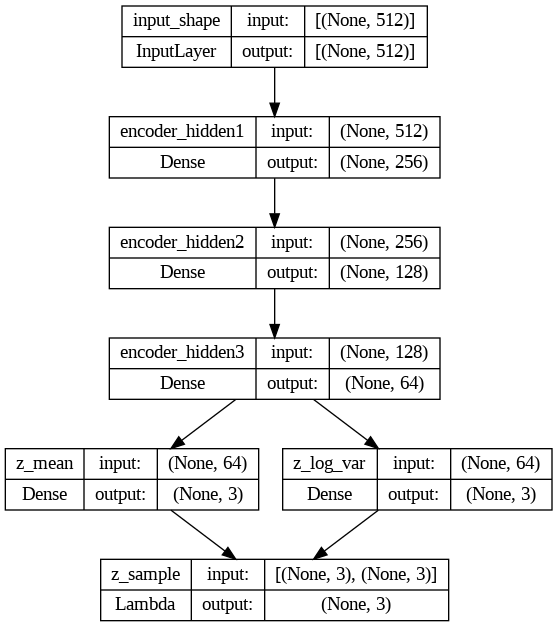

In [22]:
def encoder():
  # 인코더의 입력층을 생성합니다.
  inputs = Input(shape=(input_shape,), name='input_shape')

  # 인코더의 hidden층을 생성(784 -> 512 -> 256 -> 128)
  encoder_hidden1 = layers.Dense(intermediate_dim3, activation='relu', name='encoder_hidden1')(inputs)
  encoder_hidden2 = layers.Dense(intermediate_dim4, activation='relu', name='encoder_hidden2')(encoder_hidden1)
  encoder_hidden3 = layers.Dense(intermediate_dim5, activation='relu', name='encoder_hidden3')(encoder_hidden2)

  # 평균(mean)과 표준편차(sigma)층을 정의합니다. 
  # 이때 sigma 대신 log variance를 사용합니다. 이는 신경망의 출력은 음수를 가질 수 있지만 sigma는 항상 양수여야 하기 때문입니다. 
  # 각각 2개의 유닛을 사용했습니다.
  z_mean = layers.Dense(latent_dim, name='z_mean')(encoder_hidden3)
  z_log_var = layers.Dense(latent_dim, name='z_log_var')(encoder_hidden3)

  # 평균과 표준편차를 래핑하여 Z_sampling층을 만듭니다.

  # Z 샘플링 함수 생성
  def sampling(args):
      z_mean, z_log_var = args
      batch = shape(z_mean)[0]
      dim = shape(z_mean)[1]

      # by default, random_normal has mean = 0 and std = 1.0
      # Reparameterization Trick사용을 위해 Gussian(=normal)분포에서 랜덤변수(sample) ε추출 
      epsilon = tf.compat.v2.random.normal(shape=(batch, dim))
      return z_mean + tf.math.exp(0.5 * z_log_var) * epsilon

  #  layers.Lambda API 래핑에 사용할 함수와, 유닛수(n,)를 지정합니다.
  z_sampling = layers.Lambda(sampling, (latent_dim,), name='z_sample')([z_mean, z_log_var])

  # 하나의 입력과 다중충력을 포함하는 encoder 모델을 만듭니다.   
  return Model(inputs,[z_mean,z_log_var,z_sampling], name='encoder')

encoder = encoder()

# 인코더 네트워크를 확인합니다.
encoder.summary()

from tensorflow.keras.utils import plot_model
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_z (InputLayer)        [(None, 3)]               0         
                                                                 
 decoder_hidden1 (Dense)     (None, 64)                256       
                                                                 
 decoder_hidden2 (Dense)     (None, 128)               8320      
                                                                 
 decoder_hidden3 (Dense)     (None, 256)               33024     
                                                                 
 output (Dense)              (None, 512)               131584    
                                                                 
Total params: 173,184
Trainable params: 173,184
Non-trainable params: 0
_________________________________________________________________


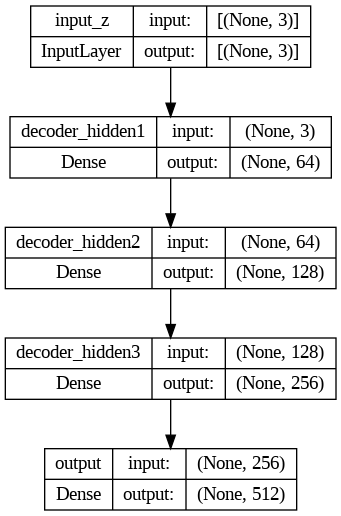

In [23]:
def decoder():
  
  # 디코더의 입력층 생성. (Decoder의 입력은 latent vector)
  input_z = Input(shape=(latent_dim,), name='input_z')

  # 디코더의 hidden층 생성
  decoder_hidden1 = layers.Dense(intermediate_dim5, activation='relu', name='decoder_hidden1')(input_z)
  decoder_hidden2 = layers.Dense(intermediate_dim4, activation='relu', name='decoder_hidden2')(decoder_hidden1)
  decoder_hidden3 = layers.Dense(intermediate_dim3, activation='relu', name='decoder_hidden3')(decoder_hidden2)

  # 디코더의 output으로 dim = 10으로 줄여 classification에 이용
  outputs = layers.Dense(original_dim, activation='sigmoid',name='output')(decoder_hidden3)

  return Model(input_z, outputs, name='decoder')

decoder = decoder()

# 디코더의 네트워크 확인.
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_shape (InputLayer)    [(None, 512)]             0         
                                                                 
 encoder (Functional)        [(None, 3),               172870    
                              (None, 3),                         
                              (None, 3)]                         
                                                                 
 decoder (Functional)        (None, 512)               173184    
                                                                 
Total params: 346,054
Trainable params: 346,054
Non-trainable params: 0
_________________________________________________________________


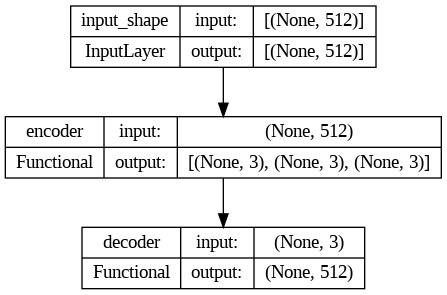

In [24]:
def vae():
  # vae는 입력으로 이미지로 들어와 encoder를 통해 z_sampling 되어 decoder로 출력됩니다.  
  inputs = Input(shape=(input_shape,), name='input_shape')
  outputs = decoder(encoder(inputs)[2]) #[0]:z_mean, [1]:z_log_var,[2]:z_sampling
  
  return Model(inputs,outputs, name='vae_mlp')

#VAE 모델 정의
model = vae()

#모델 네트워크 확인 
model.summary()
plot_model(model,to_file='vae_mlp.png',show_shapes=True)

In [25]:
# Hyperparameters
num_epochs = 100
batch_size = 100
learning_rate = 0.000001

In [26]:
# 모델 학습 loss, optimizer 정의
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)

def vae_loss(x,recon_x):
    # (1)Reconstruct loss (Marginal_likelihood) : Cross-entropy 
    z_mean,z_log_var,z_sampling = encoder(x)
    recon_x=decoder(z_sampling)
    reconstruction_loss = binary_crossentropy(x,recon_x)
    #reconstruction_loss = mse(inputs, outputs)
    reconstruction_loss *= original_dim
    # (2) KL divergence(Latent_loss)
    kl_loss = 0.5 * tf.reduce_sum(tf.square(z_mean)+ tf.exp(z_log_var)- z_log_var -1, 1)
    print("loss: ", tf.reduce_mean(reconstruction_loss + kl_loss))
    return tf.reduce_mean(reconstruction_loss + kl_loss) #ELBO(=VAE_loss)

model.compile(optimizer=adam,loss=vae_loss)

In [27]:
def KLD(x, x_pred):
  z_mean,z_log_var,z_sampling = encoder(x)
  # KL divergence(Latent_loss)
  kl_loss = 0.5 * tf.reduce_sum(tf.square(z_mean)+ tf.exp(z_log_var)- z_log_var -1, 1) 

In [28]:
#df = pd.DataFrame(x_train)
#df.isnull().any()

In [29]:
 # 모델 학습
hist = model.fit(x_train, x_train, epochs=num_epochs, batch_size=batch_size )
#학습된 VAE 모델 저장 
#model.save_weights('vae_mnist_0.h5')

Epoch 1/100
loss:  Tensor("vae_loss/Mean_1:0", shape=(), dtype=float32)
loss:  Tensor("vae_loss/Mean_1:0", shape=(), dtype=float32)
80/80 [==============================] - 2s 9ms/step - loss: 355.7184
Epoch 2/100
80/80 [==============================] - 1s 9ms/step - loss: 355.4462
Epoch 3/100
80/80 [==============================] - 1s 9ms/step - loss: 355.2079
Epoch 4/100
80/80 [==============================] - 1s 8ms/step - loss: 354.9792
Epoch 5/100
80/80 [==============================] - 1s 8ms/step - loss: 354.7636
Epoch 6/100
80/80 [==============================] - 1s 8ms/step - loss: 354.5270
Epoch 7/100
80/80 [==============================] - 1s 8ms/step - loss: 354.3007
Epoch 8/100
80/80 [==============================] - 1s 8ms/step - loss: 354.0683
Epoch 9/100
80/80 [==============================] - 1s 8ms/step - loss: 353.8084
Epoch 10/100
80/80 [==============================] - 1s 8ms/step - loss: 353.5551
Epoch 11/100
80/80 [==============================] - 1s 8m

## Learning curve

In [30]:
loss = hist.history['loss']
#plt.figure(figsize=(8, 8))
#plt.plot(loss, label = 'Training Losss')
#plt.show()

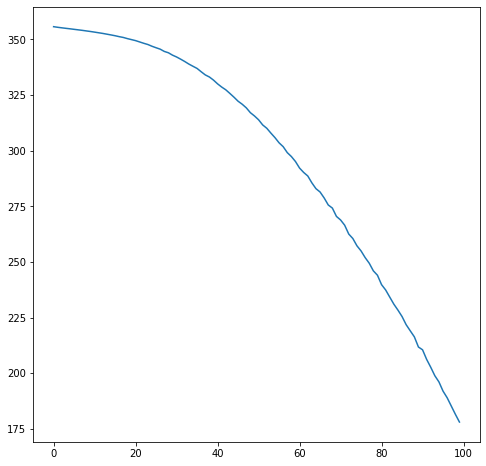

In [31]:
for i in range(len(loss)):
  if loss[i] < 0:
    loss[i] = loss[i]*-1

loss = hist.history['loss']
plt.figure(figsize=(8, 8))
plt.plot(loss, label = 'Training Losss')
plt.show()

In [32]:
test_score = model.evaluate(x_train0, x_train0, verbose=0)
prediction = model.predict(x_train0)

loss:  Tensor("vae_loss/Mean_1:0", shape=(), dtype=float32)
32/32 [==============================] - 0s 2ms/step


## MSE function구현

In [33]:
def MSE(p, q):
  return np.mean((p - q)**2)

## KLD loss function구현

In [34]:
def KLD(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

## test dataset을 활용하여 MSE 값 측정 + IQR

In [35]:
MSE_loss = []
for i in range(len(x_test)):
  MSE_loss.append(MSE(x_train0[i], prediction[i]))


print("MSE mean: ", np.mean(MSE_loss))
print("MSE variance: ", np.var(MSE_loss))
print("MSE standard deviation: ", np.std(MSE_loss))
mean_mse = np.mean(MSE_loss)
mean_lower_mse, mean_upper_mse = mean_mse - np.std(MSE_loss), mean_mse + np.std(MSE_loss)
print("mean_lower: ", mean_lower_mse)
print("mean_upper: ", mean_upper_mse)
print("MSE min: ", np.min(MSE_loss))
print("\n")

# IQR 계산
q25_mse = np.quantile(MSE_loss, 0.25)
q75_mse = np.quantile(MSE_loss, 0.75)
iqr_mse = q75_mse - q25_mse

cut_off_mse = iqr_mse*1.5
lower_mse, upper_mse = q25_mse - cut_off_mse, q75_mse + cut_off_mse
print("IQR: ", iqr_mse)
print("Lower: ", lower_mse)
print("Upper: ", upper_mse)
print("\n")              

MSE mean:  0.3378486325858905
MSE variance:  0.009596623172411445
MSE standard deviation:  0.09796235589455494
mean_lower:  0.23988627669133555
mean_upper:  0.4358109884804454
MSE min:  0.13442824301205097


IQR:  0.12159143277114726
Lower:  0.08531963477977567
Upper:  0.5716853658643647




## Loss function: MSE

In [36]:
outlier_score = model.evaluate(x_test, x_test, verbose=0) # loss 값 결과 확인

sample_size = len(x_test)                     # 보여줄 sample 갯수 설정
prediction3 = model.predict(x_test)      # test 데이터로 이미지 복원(predict 함수 사용)

# Dataframe에 저장할 list생성
Result = []

# mixed dataset내 각각의 data point마다 MSE loss를 구한다
MSE_data = []
for i in range(sample_size):
  MSE_data.append(MSE(x_test[i], prediction3[i]))

# 위에서 구한 MSE mean의 lower, upper에 따라 outlier detection 수행
for i in range(sample_size):
  if MSE_data[i] < mean_upper_mse and MSE_data[i] > mean_lower_mse:
    Result.append(0)
  else:
    Result.append(1)

# Confusion matrix
y_true = y_test
y_pred = Result
#confusion_matrix(y_true, y_pred, labels=[1,0])

# 분류 성능 평가
print("Acc: ", accuracy_score(y_true, y_pred))
print("Precision: ", precision_score(y_true, y_pred, pos_label=1))
print("Recall: ", recall_score(y_true, y_pred, pos_label=1))
print("F1 score: ", f1_score(y_true, y_pred, pos_label=1))

# ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
print("AUROC: ", auc(fpr, tpr))
print("AUPRC: ", average_precision_score(y_true, y_pred))
print("\n")

count_TP, count_TN, count_FN, count_FP = 0, 0, 0, 0
for i in range(len(y_pred)):
  if y_true[i] == 1 and y_pred[i] == 1:
    count_TP += 1
  elif y_true[i] == 1 and y_pred[i] == 0:
    count_FN += 1
  elif y_true[i] == 0 and y_pred[i] == 0:
    count_TN += 1
  else:
    count_FP += 1

print("사고를 사고로 예측(TP): ", count_TP)
print("사고를 정상으로 예측(FN): ", count_FN)
print("정상을 정상으로 예측(TN): ", count_TN)
print("정상을 사고로 예측(FP): ", count_FP)

32/32 [==============================] - 0s 2ms/step
Acc:  0.728
Precision:  0.08764940239043825
Recall:  0.3384615384615385
F1 score:  0.13924050632911392
AUROC:  0.546770876182641
AUPRC:  0.07266595157830219


사고를 사고로 예측(TP):  22
사고를 정상으로 예측(FN):  43
정상을 정상으로 예측(TN):  706
정상을 사고로 예측(FP):  229


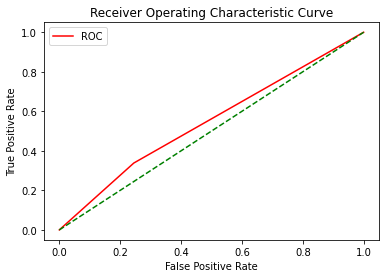

In [37]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

plot_roc_curve(fpr, tpr)

## Loss function: MSE + IQR

In [38]:
outlier_score = model.evaluate(x_test, x_test, verbose=0) # loss 값 결과 확인

sample_size = len(x_test)                     # 보여줄 sample 갯수 설정
prediction3 = model.predict(x_test)      # test 데이터로 이미지 복원(predict 함수 사용)

# Dataframe에 저장할 list생성
Result = []

# mixed dataset내 각각의 data point마다 KLD loss를 구한다
MSE_data = []
for i in range(sample_size):

  MSE_data.append(MSE(x_test[i], prediction3[i]))

# 위에서 구한 KLD mean의 lower, upper에 따라 outlier detection 수행
for i in range(sample_size):
  if MSE_data[i] < upper_mse and MSE_data[i] > lower_mse:
    Result.append(0)
  else:
    Result.append(1)

#print("--------------------------------------------------------\n")

# Confusion matrix
y_true = y_test
y_pred = Result
confusion_matrix(y_true, y_pred, labels=[1,0])

# 분류 성능 평가
print("Acc: ", accuracy_score(y_true, y_pred))
print("Precision: ", precision_score(y_true, y_pred, pos_label=1))
print("Recall: ", recall_score(y_true, y_pred, pos_label=1))
print("F1 score: ", f1_score(y_true, y_pred, pos_label=1))

# ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=1)
print("AUROC: ", auc(fpr, tpr))
print("AUPRC: ", average_precision_score(y_true, y_pred))
print("\n")

count_TP, count_TN, count_FN, count_FP = 0, 0, 0, 0
for i in range(len(y_pred)):
  if y_true[i] == 1 and y_pred[i] == 1:
    count_TP += 1
  elif y_true[i] == 1 and y_pred[i] == 0:
    count_FN += 1
  elif y_true[i] == 0 and y_pred[i] == 0:
    count_TN += 1
  else:
    count_FP += 1

print("사고를 사고로 예측(TP): ", count_TP)
print("사고를 정상으로 예측(FN): ", count_FN)
print("정상을 정상으로 예측(TN): ", count_TN)
print("정상을 사고로 예측(FP): ", count_FP)

32/32 [==============================] - 0s 2ms/step
Acc:  0.917
Precision:  0.05
Recall:  0.015384615384615385
F1 score:  0.023529411764705885
AUROC:  0.49753187988482106
AUPRC:  0.06476923076923077


사고를 사고로 예측(TP):  1
사고를 정상으로 예측(FN):  64
정상을 정상으로 예측(TN):  916
정상을 사고로 예측(FP):  19


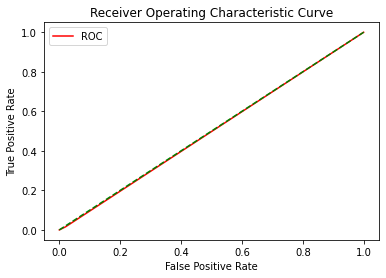

In [39]:
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

plot_roc_curve(fpr, tpr)